In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from constants import numeric_features, categorical_features
from part2.shared import load_processed_data
from part2.shared import load_train_with_validation_data
import matplotlib.pyplot as plt
from Logistic import CustomLogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
NUMBER_OF_EPOCHS = 250

In [3]:
df = load_processed_data()
df = df[df["Target"].isin(["Graduate", "Dropout"])]
df["y"] = (df["Target"] == "Graduate").astype(int)
df = df.drop(columns=["Target", "Target encoded"], errors='ignore')

In [4]:
X = df.drop(columns=["y"])
y = df["y"].values

In [5]:
num_features = [c for c in numeric_features if c in X.columns]
cat_features = [c for c in categorical_features if c in X.columns]

In [6]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [7]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [8]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [9]:
X_train_raw, X_val_raw, X_test_raw, y_train, y_val, y_test = load_train_with_validation_data(X, y)
X_train = full_pipeline.fit_transform(X_train_raw)
X_test = full_pipeline.transform(X_test_raw)
X_val = full_pipeline.transform(X_val_raw)

In [10]:
base_model = CustomLogisticRegression(
    lr=0.05,
    epochs=250,
    batch_size=256,
    verbose=True,
)

base_model.fit(X_train, y_train, X_val, y_val, X_test, y_test)
y_pred = base_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Epoch   1/250  train_loss=0.5362  test_loss=0.5264
Epoch  20/250  train_loss=0.3115  test_loss=0.2918
Epoch  40/250  train_loss=0.2792  test_loss=0.2614
Epoch  60/250  train_loss=0.2640  test_loss=0.2477
Epoch  80/250  train_loss=0.2548  test_loss=0.2401
Epoch 100/250  train_loss=0.2485  test_loss=0.2347
Epoch 120/250  train_loss=0.2439  test_loss=0.2313
Epoch 140/250  train_loss=0.2403  test_loss=0.2286
Epoch 160/250  train_loss=0.2374  test_loss=0.2266
Epoch 180/250  train_loss=0.2351  test_loss=0.2250
Epoch 200/250  train_loss=0.2332  test_loss=0.2238
Epoch 220/250  train_loss=0.2315  test_loss=0.2230
Epoch 240/250  train_loss=0.2301  test_loss=0.2221
              precision    recall  f1-score   support

           0     0.9288    0.8732    0.9002       284
           1     0.9217    0.9571    0.9391       443

    accuracy                         0.9243       727
   macro avg     0.9253    0.9152    0.9196       727
weighted avg     0.9245    0.9243    0.9239       727



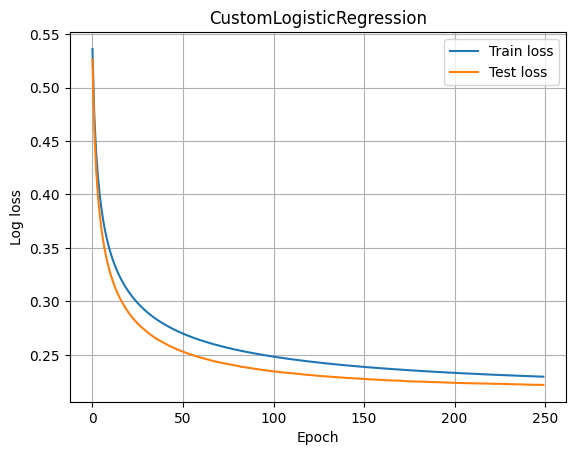

In [11]:
plt.plot(base_model.history['train'], label="Train loss")
plt.plot(base_model.history['test'], label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("CustomLogisticRegression")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
poly_pipeline = ColumnTransformer([
    ("num_poly", Pipeline([
        ("imp", SimpleImputer(strategy="mean")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("sc", StandardScaler())
    ]), num_features),
    ("cat", cat_pipeline, cat_features)
])


In [13]:
X_train_poly = poly_pipeline.fit_transform(X_train_raw)
X_val_poly = poly_pipeline.transform(X_val_raw)
X_test_poly = poly_pipeline.transform(X_test_raw)

model_poly = CustomLogisticRegression(lr=0.05, epochs=NUMBER_OF_EPOCHS, batch_size=256, verbose=True,)
model_poly.fit(X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test)

Epoch   1/250  train_loss=0.3889  test_loss=0.3700
Epoch  20/250  train_loss=0.2646  test_loss=0.2568
Epoch  40/250  train_loss=0.2477  test_loss=0.2425
Epoch  60/250  train_loss=0.2394  test_loss=0.2367
Epoch  80/250  train_loss=0.2339  test_loss=0.2361
Epoch 100/250  train_loss=0.2296  test_loss=0.2328
Epoch 120/250  train_loss=0.2264  test_loss=0.2315
Epoch 140/250  train_loss=0.2240  test_loss=0.2321
Epoch 160/250  train_loss=0.2215  test_loss=0.2309
Epoch 180/250  train_loss=0.2198  test_loss=0.2289
Epoch 200/250  train_loss=0.2180  test_loss=0.2294
Epoch 220/250  train_loss=0.2166  test_loss=0.2299
Epoch 240/250  train_loss=0.2153  test_loss=0.2293


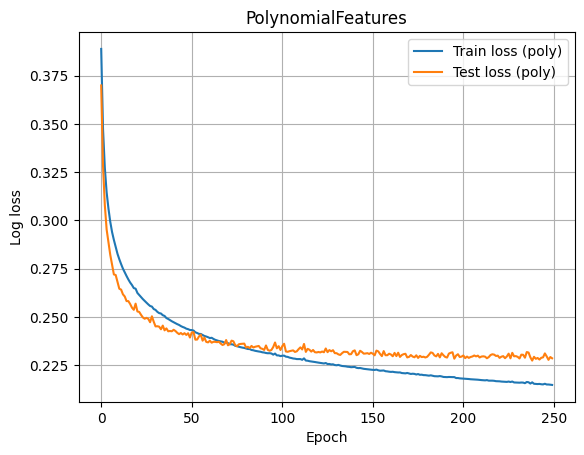

In [14]:
plt.plot(model_poly.history["train"], label="Train loss (poly)")
plt.plot(model_poly.history["test"], label="Test loss (poly)")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("PolynomialFeatures")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
y_pred_poly = model_poly.predict(X_test_poly)
print(classification_report(y_test, y_pred_poly, digits=4))


              precision    recall  f1-score   support

           0     0.9071    0.8592    0.8825       284
           1     0.9127    0.9436    0.9279       443

    accuracy                         0.9106       727
   macro avg     0.9099    0.9014    0.9052       727
weighted avg     0.9105    0.9106    0.9101       727



In [16]:
select_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("selector", SelectKBest(score_func=f_classif, k=5)),
    ("scaler", StandardScaler())
])

X_train_selected = select_pipeline.fit_transform(X_train_raw[num_features], y_train)
X_val_selected = select_pipeline.transform(X_val_raw[num_features])
X_test_selected = select_pipeline.transform(X_test_raw[num_features])


model_sel = CustomLogisticRegression(lr=0.05, epochs=250, batch_size=256, verbose=True)
model_sel.fit(X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test)

Epoch   1/250  train_loss=0.5731  test_loss=0.5664
Epoch  20/250  train_loss=0.4127  test_loss=0.3865
Epoch  40/250  train_loss=0.4047  test_loss=0.3755
Epoch  60/250  train_loss=0.4001  test_loss=0.3696
Epoch  80/250  train_loss=0.3971  test_loss=0.3658
Epoch 100/250  train_loss=0.3950  test_loss=0.3631
Epoch 120/250  train_loss=0.3935  test_loss=0.3611
Epoch 140/250  train_loss=0.3924  test_loss=0.3596
Epoch 160/250  train_loss=0.3915  test_loss=0.3584
Epoch 180/250  train_loss=0.3909  test_loss=0.3575
Epoch 200/250  train_loss=0.3903  test_loss=0.3567
Epoch 220/250  train_loss=0.3899  test_loss=0.3561
Epoch 240/250  train_loss=0.3896  test_loss=0.3556


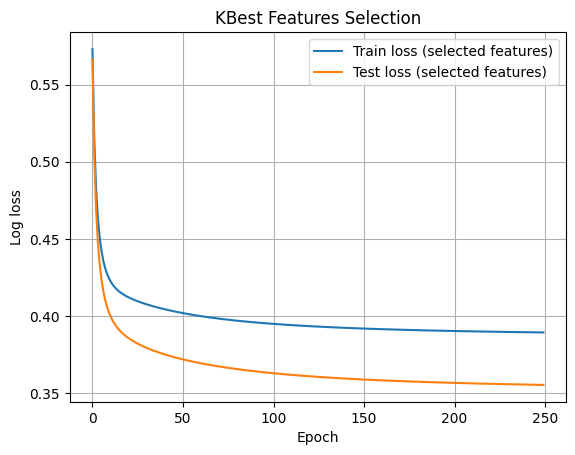

In [17]:
plt.plot(model_sel.history["train"], label="Train loss (selected features)")
plt.plot(model_sel.history["test"], label="Test loss (selected features)")
plt.title("KBest Features Selection")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
y_pred_sel = model_sel.predict(X_test_selected)
print(classification_report(y_test, y_pred_sel, digits=4))

              precision    recall  f1-score   support

           0     0.9087    0.7711    0.8343       284
           1     0.8663    0.9503    0.9064       443

    accuracy                         0.8803       727
   macro avg     0.8875    0.8607    0.8703       727
weighted avg     0.8828    0.8803    0.8782       727

